# Load modules

In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Choose $t_0$

In [264]:
def get_file(year, month, day, hour, minute):
    path_core = f'/gws/nopw/j04/cocoon/SSA_domain/ch9_wavelet/{year}/{month}'
    return f'{path_core}/{year}{month}{day}{hour}{minute}.nc'

In [265]:
year = '2024'
month = '09'
day = '20'
hour = '03'
minute = '00'

In [266]:
filename = get_file(year=year, month=month, day=day, hour=hour, minute=minute)

In [267]:
input_raw = process_file(filename)

# Preprocessing

In [268]:
norm_path = "/home/users/mendrika/EPS-Impact-Case-AI-Nowcasting/model/africa/normalisation/parameters/normalisation.json"
input_proc = PreProcessor.preprocess(norm_path, input_raw)
x = input_proc.unsqueeze(0)

# Prediction

In [269]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_t1.to(device)
model_t3.to(device)

x = input_proc.unsqueeze(0).to(device)  # Move input to same device

In [270]:
# === Run inference ===
with torch.no_grad():
    pred_t1 = torch.sigmoid(model_t1(x)).squeeze().cpu().numpy()
    pred_t3 = torch.sigmoid(model_t3(x)).squeeze().cpu().numpy()

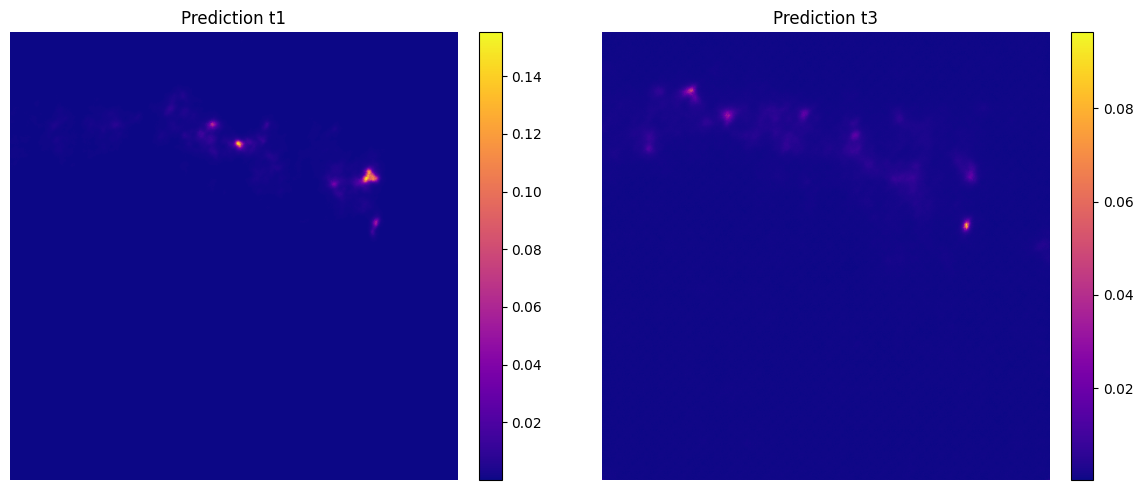

In [271]:
# Flip the predictions vertically for map convention
pred_t1_flipped = np.flipud(pred_t1)
pred_t3_flipped = np.flipud(pred_t3)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(pred_t1_flipped, cmap="plasma")
axes[0].set_title("Prediction t1")
axes[0].axis("off")
plt.colorbar(axes[0].images[0], ax=axes[0], fraction=0.046, pad=0.04)

axes[1].imshow(pred_t3_flipped, cmap="plasma")
axes[1].set_title("Prediction t3")
axes[1].axis("off")
plt.colorbar(axes[1].images[0], ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


# Save nowcasts

In [272]:
# === Create temporary directory ===
outdir = f"tmp_vis/{year}{month}{day}_{hour}{minute}"
os.makedirs(outdir, exist_ok=True)

# === Save prediction images with transparent background ===
t1_path = os.path.join(outdir, "pred_t1.png")
t3_path = os.path.join(outdir, "pred_t3.png")
html_path = os.path.join(outdir, "prediction_map.html")

# Threshold below which pixels are invisible
threshold = 0.01

# Mask background (make transparent)
masked_t1 = np.ma.masked_where(pred_t1 < threshold, pred_t1)
masked_t3 = np.ma.masked_where(pred_t3 < threshold, pred_t3)

# Flip vertically to match map convention
masked_t1_flipped = np.flipud(masked_t1)
masked_t3_flipped = np.flipud(masked_t3)

# Save with transparency — only blobs visible
plt.imsave(t1_path, masked_t1_flipped, cmap="plasma")
plt.imsave(t3_path, masked_t3_flipped, cmap="plasma")

# Save a standalone colorbar image
cb_path = os.path.join(outdir, "colorbar.png")
gradient = np.linspace(0, 1, 256).reshape(1, -1)

fig, ax = plt.subplots(figsize=(4, 0.4))  # Wide and short
ax.imshow(gradient, aspect='auto', cmap='plasma')
ax.set_axis_off()
plt.savefig(cb_path, bbox_inches='tight', pad_inches=0)
plt.close()


# Load ground truths

In [3]:
LAT_MIN, LAT_MAX = -41.989723, 27.232262
LON_MIN, LON_MAX = -27.161226, 79.549774

In [273]:
sys.path.insert(1, "/home/users/mendrika/SSA/SA/module")
import snflics

In [274]:
DATA_PATH = "/gws/nopw/j04/cocoon/SSA_domain/ch9_wavelet/"

In [275]:
from scipy.ndimage import zoom

In [276]:
def resize_like_training(core_np):
    """
    Match training-time preprocessing: zoom → interpolate
    """
    # Step 1: resize using scipy.ndimage.zoom (bilinear)
    zoom_factors = (1024 / core_np.shape[0], 1024 / core_np.shape[1])
    resized_np = zoom(core_np, zoom=zoom_factors, order=1)

    # Step 2: resize using PyTorch F.interpolate (bilinear, align_corners=False)
    t = torch.from_numpy(resized_np).unsqueeze(0).unsqueeze(0).float()  # (1, 1, H, W)
    resized_torch = torch.nn.functional.interpolate(t, size=(512, 512), mode="bilinear", align_corners=False)
    return resized_torch.squeeze().numpy()

# === Get lead time files ===
time_t0 = snflics.get_time(filename)
files_info = [update_hour(time_t0, h) for h in [1, 3]]
files = [DATA_PATH + info[1] for info in files_info]
core_series = [prepare_core(f) for f in files]

# === Save ground truth core masks as transparent PNGs ===
gt1_path = os.path.join(outdir, "gt_t1.png")
gt3_path = os.path.join(outdir, "gt_t3.png")

threshold = 0  # Mask where core == 0

resized_gt1 = resize_like_training(core_series[0])
resized_gt3 = resize_like_training(core_series[1])

masked_gt1 = np.ma.masked_where(resized_gt1 <= threshold, resized_gt1)
masked_gt3 = np.ma.masked_where(resized_gt3 <= threshold, resized_gt3)

# Flip vertically to match map orientation
masked_gt1_flipped = np.flipud(masked_gt1)
masked_gt3_flipped = np.flipud(masked_gt3)

plt.imsave(gt1_path, masked_gt1_flipped, cmap="viridis")
plt.imsave(gt3_path, masked_gt3_flipped, cmap="viridis")


In [277]:
core_series[0].shape

(2080, 2268)

In [278]:
end = time.time()
duration = end-start
duration/60

0.6981634656588237